## Install Required Packages

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

## Import Necessary Libraries

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

## Download and Unzip Dataset

In [ ]:
!gdown --id 1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL -O GRID_dataset.zip
!unzip -q GRID_dataset.zip

## Define Vocabulary and Character Mapping Layer

In [ ]:
# Define the list of all valid characters in the dataset
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

# Map characters to numbers and vice versa
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=vocab,
    oov_token=""
)
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)

# Show vocabulary info
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}\n"
    f"(Size = {char_to_num.vocabulary_size()})"
)

## Define Video Loading Function

In [5]:
def load_video(path: str) -> tf.Tensor:

    # Open video file
    cap = cv2.VideoCapture(path)
    frames = []

    # Loop through all video frames
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret or frame is None:
            print(f"Skipping invalid frame in {path}")
            continue

        try:

            # Ensure frame is valid RGB
            if frame.ndim != 3 or frame.shape[2] != 3:
                raise ValueError(f"Expected RGB frame but got shape {frame.shape}")
            frame = tf.convert_to_tensor(frame, dtype=tf.uint8)

            # Check for minimum dimensions before cropping
            if frame.shape[0] < 236 or frame.shape[1] < 220:
                raise ValueError(f"Invalid frame shape: {frame.shape}")

            # Convert to grayscale and crop region of interest (RoI) (46x140)
            frame = tf.image.rgb_to_grayscale(frame)
            frame = frame[190:236, 80:220, :]

            # Check final frame shape
            if frame.shape != (46, 140, 1):
                raise ValueError(f"Frame shape mismatch after crop: {frame.shape}")

            frames.append(frame)

        except Exception as e:
            print(f"Frame error in {path}: {e}")
            continue

    cap.release()

    # Return zero tensor if no valid frames found
    if not frames:
        print(f"Warning: No frames in {path}")
        return tf.zeros((75, 46, 140, 1), dtype=tf.float32)

    # Pad or trim to exactly 75 frames
    if len(frames) < 75:
        frames += [frames[-1]] * (75 - len(frames))
    else:
        frames = frames[:75]

    # Normalize video frames
    frames = tf.stack(frames)
    frames = tf.cast(frames, tf.float32)
    mean = tf.reduce_mean(frames)
    std = tf.math.reduce_std(frames)
    return (frames - mean) / (std + 1e-6)

## Define Alignment Loading Function

In [6]:
def load_alignments(path: str) -> tf.Tensor:

    # Read alignment file
    with open(path, 'r') as f:
        lines = f.readlines()

    # Extract non-silence tokens
    tokens = ""
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 3 and parts[2] != "sil":
            tokens += " " + parts[2]
    tokens = tokens.strip()

    # Return empty tensor if no tokens
    if not tokens:
        return tf.constant([], dtype=tf.int64)

    # Convert characters to numeric sequence
    chars = tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), (-1,))
    return char_to_num(chars)

## Wrap Data Loading for TensorFlow

In [7]:
def load_data(path: tf.Tensor):

    # Decode file path from tensor to string
    path = path.numpy().decode('utf-8')
    file_name = os.path.splitext(os.path.basename(path))[0]

    # Construct video and alignment paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    # Load video frames and label sequence
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

# TensorFlow wrapper to call Python function inside data pipeline
def mappable_function(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Build the Data Pipeline

In [8]:
# Create dataset of video files and shuffle
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)

# Map video and label loader function
data = data.map(mappable_function)

# Batch and pad inputs to 75×46×140×1 shape, and prefetch for performance
data = data.padded_batch(batch_size=2, padded_shapes=([75, 46, 140, 1], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Split into training and test sets
train = data.take(450)
test = data.skip(450)

## Visualize Sample Video and Alignment

lay blue with l zero please


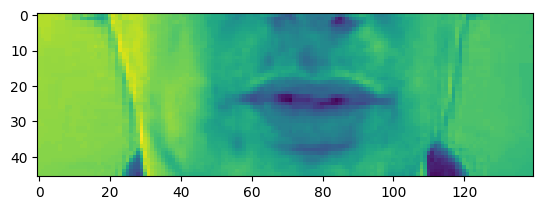

In [9]:
# Load one batch
frames, alignments = data.as_numpy_iterator().next()
sample = data.as_numpy_iterator()
val = sample.next()

# Normalize video to 0-255 and save as GIF
video = val[0][0]
video = np.squeeze(video, axis=-1)
vmin, vmax = video.min(), video.max()
video_norm = (video - vmin) / (vmax - vmin)
video_uint8 = (video_norm * 255).astype(np.uint8)

# Save video as animated GIF
imageio.mimsave('./Animation.gif', list(video_uint8), fps=10)

# Show one specific frame
plt.imshow(video_uint8[30])

# Decode and print alignment for first example
decoded = tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])
print(decoded.numpy().decode('utf-8'))

# Design Deep Neural Network (3D-CNN + BiLSTM Model)

In [ ]:
# Import essential model-building layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Define model architecture
model = Sequential()

# Add first 3D convolution layer with 128 filters
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))  # Reduce width and height by half

# Add second 3D convolution layer with 256 filters
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Add third 3D convolution layer with 75 filters
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Flatten the spatial dimensions using TimeDistributed wrapper
model.add(TimeDistributed(Flatten()))

# Add first bidirectional LSTM to learn temporal dependencies
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))  # Add dropout for regularization

# Add second bidirectional LSTM
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

# Output layer with softmax over character vocabulary
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

In [11]:
# Display model architecture summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

## Connect to Drive

In [12]:
from google.colab import drive

# Mount Google Drive to load and save checkpoints
drive.mount('/content/drive')

Mounted at /content/drive


## Set Up Learning Rate Scheduler

In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate scheduler to reduce LR
def scheduler(epoch: int):
    if epoch < 30:
        return 1e-3
    else:
        return 1e-4

# Wrap scheduler in a TensorFlow callback
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Create Custom CTCLoss Class

In [14]:
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

# Register the class so it can be saved/loaded with a model
@register_keras_serializable()
class CTCLoss(tf.keras.losses.Loss):

    # Compute the CTC loss between predicted sequences and ground truth
    def call(self, y_true, y_pred):

        # Compute batch size, input sequence length, and label sequence length
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        # Create tensors for input and label lengths
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        # Return the CTC loss for the entire batch
        return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

## Load the Best Saved Model

In [15]:
from tensorflow.keras.models import load_model

# Load the trained model and register custom CTCLoss for deserialization
model = load_model(
    '/content/drive/MyDrive/Labiomancy_checkpoints/Best_model.keras',
    custom_objects={'CTCLoss': CTCLoss}
)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,415,774 (96.95 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,943,850 (64.64 MB)

## Compile Model and Define Model Checkpoint  

In [16]:
# Compile model with Adam optimizer and CTC loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create checkpoint directory inside Drive
checkpoint_dir = '/content/drive/MyDrive/Labiomancy_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup checkpoint callback to save best model by validation loss
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'Best_model.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

## Create Callback to Decode and Display Predictions


In [18]:
class ProduceExample(tf.keras.callbacks.Callback):

    # Initialize with dataset (store dataset directly, not iterator)
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None) -> None:
        try:

            # Create a fresh iterator and get one batch of data
            data = next(iter(self.dataset))
            # Unpack batch into videos and labels
            videos, labels = data

            # Predict on videos using the current model
            yhat = self.model.predict(videos)

            # Decode predicted sequences using CTC greedy decoding
            decoded = tf.keras.backend.ctc_decode(
                yhat,
                input_length=[yhat.shape[1]] * yhat.shape[0],
                greedy=True
            )[0][0].numpy()

            # Iterate over first two examples or fewer
            for i in range(min(2, len(yhat))):
                # Convert original labels indices to readable text
                original = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
                # Convert decoded predictions indices to readable text
                predicted = tf.strings.reduce_join(num_to_char(decoded[i])).numpy().decode("utf-8")

                # Print the original and predicted texts
                print("Original:", original)
                print("Prediction:", predicted)
                # Print a separator for readability
                print("~" * 100)

        except Exception as e:
            # Handle exceptions gracefully without stopping training
            print(f"[Callback Error] Skipping example callback due to: {e}")

# Show predictions after each epoch using test set
example_callback = ProduceExample(test)

## Calculate Character-Level Accuracy

In [19]:
from sklearn.metrics import accuracy_score

class CharacterAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()

        # Store dataset to compute accuracy on samples
        self.dataset = dataset
        self.accuracy_per_epoch = []

    def decode_seq(self, seq):

        # Convert sequence indices to characters, ignore padding (0)
        return [num_to_char(c).numpy().decode('utf-8') for c in seq if c != 0]

    def on_epoch_end(self, epoch, logs=None):
        y_true_chars = []
        y_pred_chars = []

        # Take only 5 batches for faster evaluation
        for batch in self.dataset.take(5):
            videos, labels = batch
            yhat = self.model.predict(videos)

            # Decode predictions using greedy CTC decoding
            decoded = tf.keras.backend.ctc_decode(
                yhat,
                input_length=[yhat.shape[1]] * yhat.shape[0],
                greedy=True
            )[0][0].numpy()

            # Compare each true and predicted sequence character-wise
            for true_seq, pred_seq in zip(labels.numpy(), decoded):
                true_dec = self.decode_seq(true_seq)
                pred_dec = self.decode_seq(pred_seq)
                min_len = min(len(true_dec), len(pred_dec))
                y_true_chars.extend(true_dec[:min_len])
                y_pred_chars.extend(pred_dec[:min_len])

        # Compute accuracy score and save it
        acc = accuracy_score(y_true_chars, y_pred_chars)
        self.accuracy_per_epoch.append(acc)
        print(f"\n[Epoch {epoch+1}] Character-Level Accuracy: {acc:.4f}")

# Initialize callback with test dataset
acc_callback = CharacterAccuracyCallback(test)

## Save Training History

In [ ]:
import pickle

class HistorySaverCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.history = {}

        # Load existing history if available
        if os.path.exists(self.save_path):
            with open(self.save_path, 'rb') as f:
                self.history = pickle.load(f)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Append current epoch metrics to history dictionary
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # Save updated history to disk
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

        # Confirm that history was saved successfully
        print(f"[Epoch {epoch+1}] History saved to {self.save_path}")

# Create and initialize the callback with path to Drive
history_saver = HistorySaverCallback('/content/drive/MyDrive/Labiomancy_checkpoints/History_live.pkl')

## Train the Model

In [ ]:
# Resume training with all callbacks
history = model.fit(
    train,
    validation_data=test,
    initial_epoch=10,
    epochs=70,
    callbacks=[acc_callback, checkpoint_callback, schedule_callback, example_callback, history_saver]
)

# Make Prediction from Test Set

In [22]:
# Prepare one test batch
test_data = test.as_numpy_iterator()
sample = test_data.next()

# Run prediction on the batch
yhat = model.predict(sample[0])

# Decode the predicted sequences using CTC greedy decoder
input_len = [yhat.shape[1]] * yhat.shape[0]
decoded = tf.keras.backend.ctc_decode(yhat, input_length=input_len, greedy=True)[0][0].numpy()

# Print ground truth character sequences
print('~' * 100)
print('Original Texts:')
for sentence in sample[1]:
    print(tf.strings.reduce_join([num_to_char(char) for char in sentence]).numpy().decode('utf-8'))

# Print predicted character sequences
print('~' * 100)
print('Predicted Texts:')
for sentence in decoded:
    print(tf.strings.reduce_join([num_to_char(char) for char in sentence]).numpy().decode('utf-8'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original Texts:
place blue by j one again
bin green in g six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Predicted Texts:
place blue by j one again
bin green in g six now


# Evaluation

---



## Define Decoding Helper

In [ ]:
# Convert sequence of integers to readable characters (ignore padding)
def decode_seq(seq):
    return [num_to_char(c).numpy().decode('utf-8') for c in seq if c != 0]

## Collect Classification Report from Model Predictions

In [25]:
from sklearn.metrics import classification_report

# Initialize empty lists to store all true and predicted characters
y_true_chars = []
y_pred_chars = []

# Iterate through the first 10 batches of the test dataset
for i, batch in enumerate(test.take(10)):
    videos, labels = batch  # Unpack the batch into videos and their true labels

    # Run inference on the batch using the trained model
    yhat = model.predict(videos)

    # Decode the model's predictions using CTC decoding (greedy strategy)
    decoded = tf.keras.backend.ctc_decode(
        yhat,
        input_length=[yhat.shape[1]] * yhat.shape[0],
        greedy=True  # Use greedy decoding instead of beam search
    )[0][0].numpy()

    # Decode and align true and predicted character sequences
    for true_seq, pred_seq in zip(labels.numpy(), decoded):
        true_dec = decode_seq(true_seq)
        pred_dec = decode_seq(pred_seq)

        # Truncate both to the same length to compare only aligned parts
        min_len = min(len(true_dec), len(pred_dec))

        # Add the aligned true and predicted characters to their respective lists
        y_true_chars.extend(true_dec[:min_len])
        y_pred_chars.extend(pred_dec[:min_len])

# Print a detailed classification report comparing predicted vs true characters
print(classification_report(
    y_true_chars,
    y_pred_chars,
    digits=4,
    zero_division=0
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
              precision    recall  f1-score   support

                 0.0000    0.0000    0.0000         0
                 0.9700    0.9700    0.9700       100
           a     1.0000    1.0000    1.0000        31
           b     1.0000    1.0000    1.0000        15
           c     1.0000    1.0000    1.0000         6
           d     1.0000    1.0000    1.0000         8
           e     0.9688    0.9841    0.9764        63
           f     1.0000    1.0000    1.0000         3
           g     1.0000    1.0000    1.0000        16
           h     1.0000    1.0000    1.0000        16
           i   

## Plot Loss and Accuracy from Training History

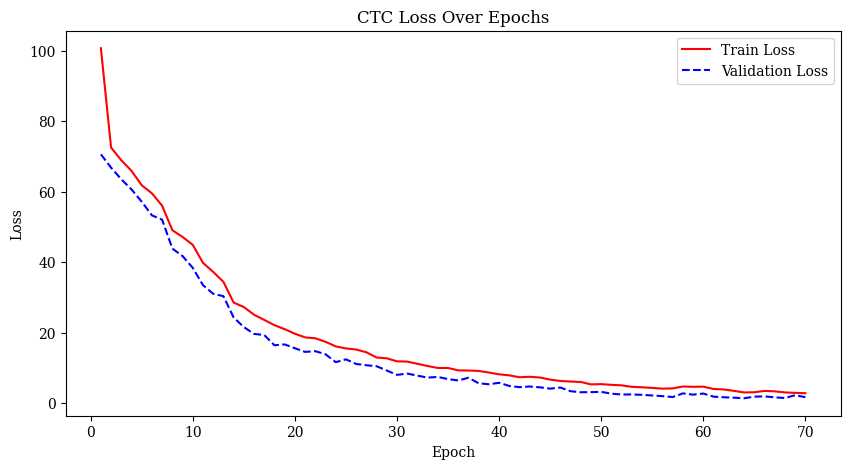

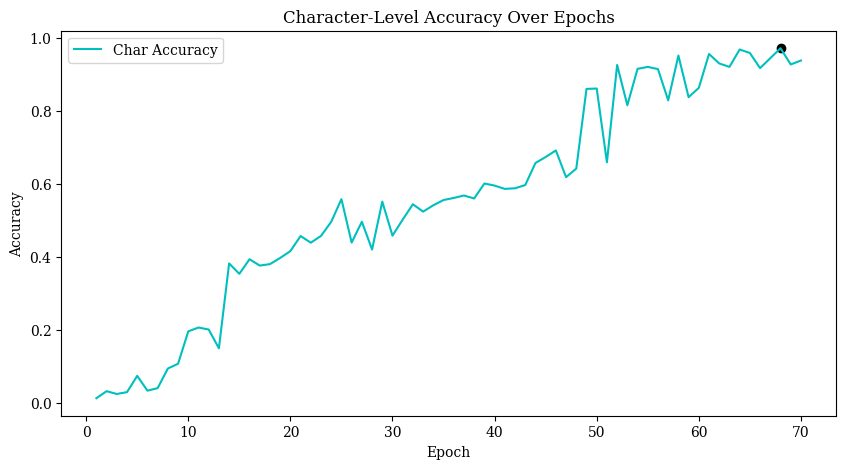

In [26]:
# Set global font to Serif
plt.rcParams['font.family'] = 'serif'

hist = history.history

# Define epoch range
epochs = range(1, len(hist['loss']) + 1)

# Plot CTC loss using history object
plt.plot(epochs, hist['loss'], 'r-', label='Train Loss')
if 'val_loss' in hist:
    plt.plot(epochs, hist['val_loss'], 'b--', label='Validation Loss')
plt.title('CTC Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.grid(True)
plt.legend()
plt.show()

# Plot char accuracy from callback
plt.plot(range(1, len(acc_callback.accuracy_per_epoch)+1),
         acc_callback.accuracy_per_epoch, 'c-', label='Char Accuracy')
plt.title('Character-Level Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.grid(True)
plt.legend()
plt.show()

## Plot Character-Level Confusion Matrix

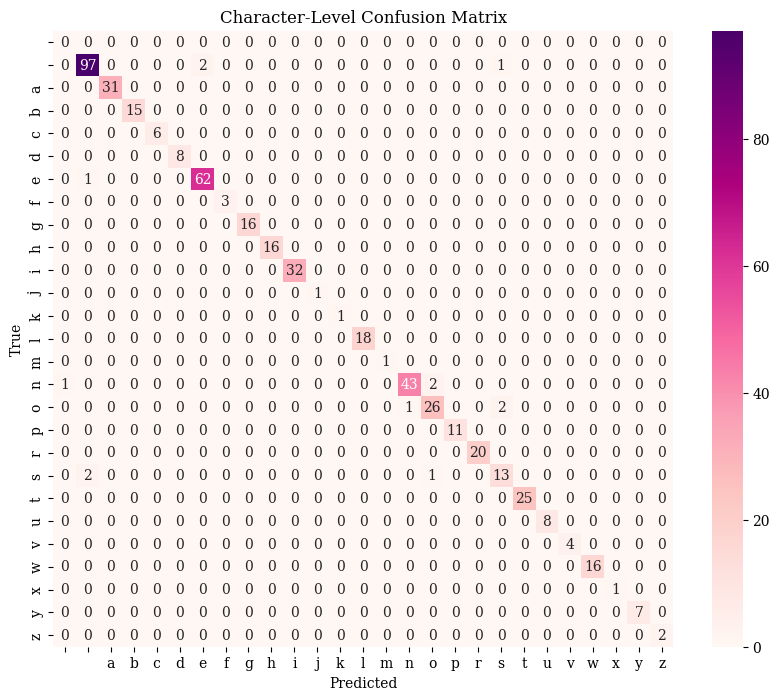

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use serif font globally
plt.rcParams['font.family'] = 'serif'

# Create confusion matrix from true vs predicted characters
unique_labels = sorted(set(y_true_chars + y_pred_chars))
cm = confusion_matrix(y_true_chars, y_pred_chars, labels=unique_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    cmap='RdPu'
)
plt.title('Character-Level Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Print Character-Level Metrics

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute and print key character-level metrics
char_acc   = accuracy_score(y_true_chars, y_pred_chars)
char_prec  = precision_score(y_true_chars, y_pred_chars, average='macro', zero_division=0)
char_rec   = recall_score(y_true_chars, y_pred_chars, average='macro', zero_division=0)
char_f1    = f1_score(y_true_chars, y_pred_chars, average='macro', zero_division=0)

print(f"Character-Level Accuracy:  {char_acc:.4f}")
print(f"Character-Level Precision: {char_prec:.4f}")
print(f"Character-Level Recall:    {char_rec:.4f}")
print(f"Character-Level F1 Score:  {char_f1:.4f}")

Character-Level Accuracy:  0.9738
Character-Level Precision: 0.9491
Character-Level Recall:    0.9481
Character-Level F1 Score:  0.9486


# View a Clean Table Summary of Convolutional Layers

In [29]:
import pandas as pd

# Build a summary DataFrame for each layer of the model
def get_all_layers_table(model):
    data = []

    for layer in model.layers:
        config = layer.get_config()
        name = layer.name
        layer_type = layer.__class__.__name__

        # Safe access to output shape
        try:
            output_shape = layer.output.shape
        except:
            output_shape = '-'

        # Gather layer-specific parameters
        kernel_size = config.get('kernel_size', '-')
        filters = config.get('filters', config.get('units', '-'))
        strides = config.get('strides', '-')
        dropout_rate = getattr(layer, 'rate', '-') if layer_type == 'Dropout' else '-'

        data.append([
            name, layer_type, kernel_size, filters, strides, dropout_rate, output_shape
        ])

    return pd.DataFrame(data, columns=[
        "Layer Name", "Layer Type", "Kernel Size", "Filters / Units", "Stride", "Dropout Rate", "Output Shape"
    ])

# Display the table
layer_table = get_all_layers_table(model)
print(layer_table.to_string())

          Layer Name       Layer Type Kernel Size Filters / Units     Stride Dropout Rate              Output Shape
0             conv3d           Conv3D   (3, 3, 3)             128  (1, 1, 1)            -  (None, 75, 46, 140, 128)
1         activation       Activation           -               -          -            -  (None, 75, 46, 140, 128)
2      max_pooling3d     MaxPooling3D           -               -  (1, 2, 2)            -   (None, 75, 23, 70, 128)
3           conv3d_1           Conv3D   (3, 3, 3)             256  (1, 1, 1)            -   (None, 75, 23, 70, 256)
4       activation_1       Activation           -               -          -            -   (None, 75, 23, 70, 256)
5    max_pooling3d_1     MaxPooling3D           -               -  (1, 2, 2)            -   (None, 75, 11, 35, 256)
6           conv3d_2           Conv3D   (3, 3, 3)              75  (1, 1, 1)            -    (None, 75, 11, 35, 75)
7       activation_2       Activation           -               -       